# Wordclouds for low, medium and high sentiment tweets

Currently only for 19VzlaEnLaCalle (2017/04/19 to 2017/04/22)

In [190]:
import pandas as pd
import numpy as np
import os
import re
import nltk
from nltk.corpus import stopwords
#from stop_words import get_stop_words
from wordcloud import WordCloud 
import gensim
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from sklearn.metrics.pairwise import cosine_similarity

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

## Import and preprocess data

In [10]:
# The Sentiment Analysis API evaluates text input and returns a sentiment score for each document, 
# ranging from 0 (negative) to 1 (positive).
df = pd.read_csv('data/sentiment/19VzlaEnLaCalle_2017_04_19_to_2017_04_22_sent.csv')
df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,Somos el 95% de OPOSITORES el CNE lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895
1,1,desdevargas,2017-04-21 17:37,1,1,# 19VzlaEnLaCalle y en los puntos rojos de Var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140
2,2,incesamazonas,2017-04-21 16:38,0,0,Retweeted ANTV VENEZUELA (@ANTV_VENEZUELA): # ...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037
3,3,incesamazonas,2017-04-21 16:28,0,0,Retweeted Elias Jaua ( @ JauaMiranda): # 19vzl...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,Retweeted Mando Militar ( @ MandoMilitar): # 1...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838


In [12]:
# Sample of tweets
#df_sample = df[:100]
#tweets = " ".join(tweet for tweet in df.text)

len(df)

21091

### Clean data, mostly similar to cleaning in tweet_visualizations.ipynb

In [13]:
def standardize_text(df, text_field):
    df[text_field] = df[text_field].str.replace(r"http\S+", "")
    df[text_field] = df[text_field].str.replace(r"http", "")
    df[text_field] = df[text_field].str.replace(r"pic.twitter.com\S+", "")
    df[text_field] = df[text_field].str.replace(r"@\S+", "")
    df[text_field] = df[text_field].str.replace(r"[^A-Za-z0-9(),!?@\'\`\"\_\n]", " ")
    df[text_field] = df[text_field].str.replace(r"@", "at")
    df[text_field] = df[text_field].str.lower()
    return df


df_standardized = standardize_text(df, "text")

#cleanreviews.to_csv("cleanreviews_NYC.csv")
df_standardized.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838


In [24]:
df['text'][150]

'  19vzlaenlacalle   20abril carlos moreno   caracas que en tu conciencia pese at nicolasmaduro'

In [16]:
# Change accented to plain text
def remove_accents(df):
    df = re.sub(r'é', 'e', df)
    df = re.sub(r'á', 'a', df)
    df = re.sub(r'ó', 'o', df)
    df = re.sub(r'í', 'i', df)
    df = re.sub(r'ñ', 'n', df)
    df = re.sub(r'ú', 'u', df)
    return df

df['text'] = df['text'].apply(remove_accents)
df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838


In [17]:
#Don't run: integrated in 'standardize_text' function above
#def clean_pictwit(df):
#    df = re.sub("pictwitter\w*", '', df)
#    return df
#    
#df['text_nopictwit'] = df['text'].apply(clean_pictwit)
#df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,text_nopictwit
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,somos el 95 de opositores el cne lo q tiene q...
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,19vzlaenlacalle y en los puntos rojos de var...
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,retweeted antv venezuela ( 19vzlaenlacalle e...
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,retweeted elias jaua ( at jauamiranda) 19vz...
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,retweeted mando militar ( at mandomilitar) ...


In [233]:
# Just a check if columns are similar
indices = df.loc[df['text'] != df['text_nopictwit']]
#indices   # no differences if empty

In [23]:
# Example after initial cleaning
print(df['text'].iloc[150])

  19vzlaenlacalle   20abril carlos moreno   caracas que en tu conciencia pese at nicolasmaduro


### Tokenize

In [25]:
from nltk.tokenize import RegexpTokenizer

tokenizer = RegexpTokenizer(r'\w+')   # separate sentences into different words

df["tokens"] = df["text"].apply(tokenizer.tokenize)
#df.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,text_nopictwit,tokens
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,somos el 95 de opositores el cne lo q tiene q...,"[somos, el, 95, de, opositores, el, cne, lo, q..."
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,19vzlaenlacalle y en los puntos rojos de var...,"[19vzlaenlacalle, y, en, los, puntos, rojos, d..."
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,retweeted antv venezuela ( 19vzlaenlacalle e...,"[retweeted, antv, venezuela, 19vzlaenlacalle, ..."
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,retweeted elias jaua ( at jauamiranda) 19vz...,"[retweeted, elias, jaua, at, jauamiranda, 19vz..."
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,retweeted mando militar ( at mandomilitar) ...,"[retweeted, mando, militar, at, mandomilitar, ..."


In [32]:
# Example after tokenization
print(df['tokens'].iloc[2000])

['retweeted', 'guerrera', 'elite', 'gar', 'at', 'venezolanamay', '19vzlaenlacalle', 'gnb', 'arrastra', 'a', 'una', 'mujer', 'indefensa', 'violan', 'sus']


### Remove stop words

In [28]:
# Get stop words
from nltk.corpus import stopwords
nltk.download('stopwords')
stop = stopwords.words('spanish')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mspronk/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [29]:
# Exclude stopwords with Python's list comprehension and pandas.DataFrame.apply.
df['nostop'] = df['tokens'].apply(lambda x: [item for item in x if item not in stop])

In [33]:
# Example after removing stopwords
print(df['nostop'].iloc[2000])

['retweeted', 'guerrera', 'elite', 'gar', 'at', 'venezolanamay', '19vzlaenlacalle', 'gnb', 'arrastra', 'mujer', 'indefensa', 'violan']


### Lemmatization

In [34]:
# Lemmatization (return "base" of words)
from nltk.stem.wordnet import WordNetLemmatizer
nltk.download('wordnet')
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package wordnet to /Users/mspronk/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [35]:
def lemmatize_text(text):
    return [lemmatizer.lemmatize(x) for x in text]

df['lemmas'] = df['nostop'].apply(lemmatize_text)

In [41]:
# Example after lemmatization
print(df['lemmas'].iloc[2000])

['retweeted', 'guerrera', 'elite', 'gar', 'at', 'venezolanamay', '19vzlaenlacalle', 'gnb', 'arrastra', 'mujer', 'indefensa', 'violan']


In [43]:
df['language'].unique()

array(['es', 'en', 'pt', 'gl', 'fr', 'hu', 'de', 'cs', 'ar', 'it', 'nl',
       'hr', 'ms', 'fi'], dtype=object)

In [49]:
df_es = df[df['language']=='es']
len(df_es)

20246

## Wordclouds

In [50]:
#Wordcloud for all tweets
all_tweets = df_es['lemmas'].tolist()

def flatten(inputdata):
    flat_list = [item for sublist in inputdata for item in sublist]
    return flat_list

all_tweets_onelist = flatten(all_tweets)
#all_tweets_onelist

In [58]:
def make_wordcloud(list):
    wc=WordCloud(min_font_size = 8, max_font_size=100, 
                      max_words=200,colormap="Reds", contour_width = 1, 
                      contour_color = "Red",collocations = False,
                      background_color="white").generate(' '.join(list))
    return wc

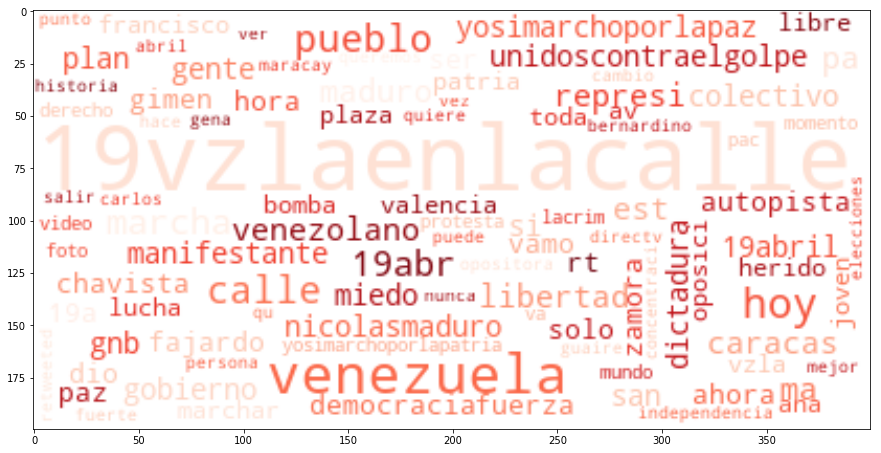

In [59]:
wc = make_wordcloud(all_tweets_onelist)
plt.figure(figsize=(15,10))
plt.imshow(wc, interpolation='bilinear')

## Wordcloud low sentiment

In [ ]:
def flatten(inputdata):
    flat_list = [item for sublist in inputdata for item in sublist]
    return flat_list

In [52]:
# Same, but for low sentiment tweets
df_lowsent = df_es[df_es['sentiment']<.20]
print(len(df_lowsent))
   
# Convert to list for input in wordcloud    
tweets_lowsent = df_lowsent['lemmas'].tolist()

tweets_lowsent_list = flatten(tweets_lowsent)

1880


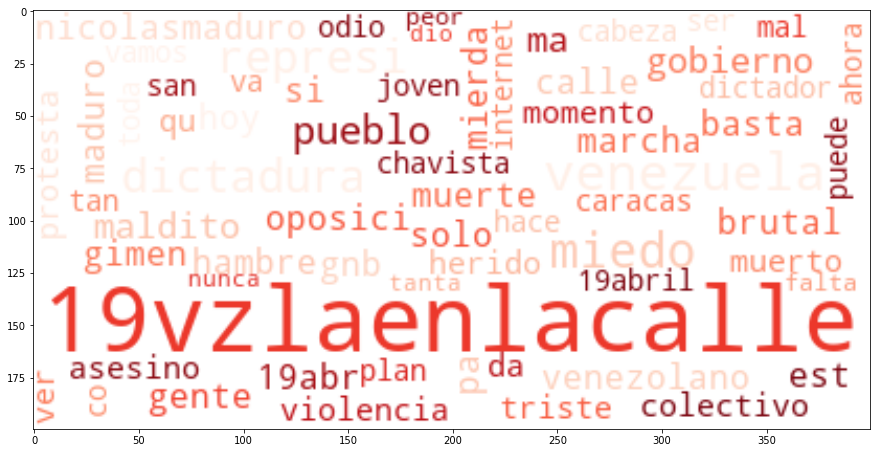

In [65]:
wc_lowsent = make_wordcloud(tweets_lowsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_lowsent, interpolation='bilinear')

## Wordcloud high sentiment

In [54]:
# Same, but for high sentiment tweets
df_highsent = df_es[df_es['sentiment']>.80]
print(len(df_highsent))
   
# Convert to list for input in wordcloud    
tweets_highsent = df_highsent['lemmas'].tolist()

tweets_highsent_list = flatten(tweets_highsent)

2002


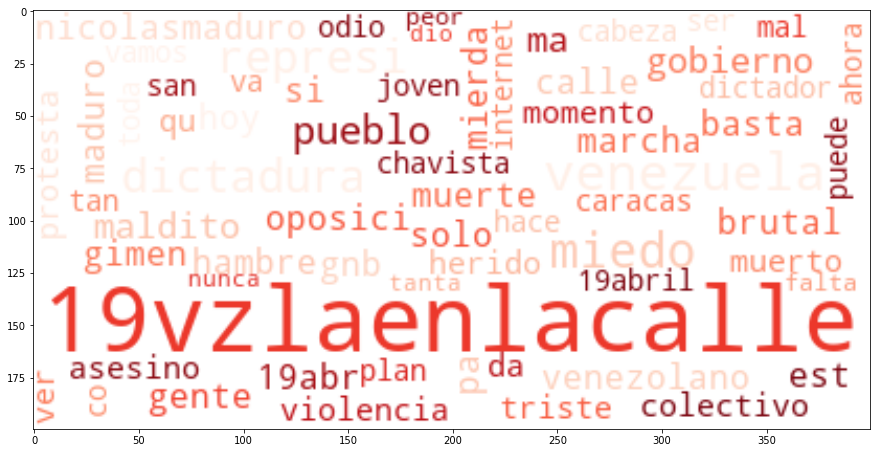

In [66]:
wc_hightsent = make_wordcloud(tweets_highsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_lowsent, interpolation='bilinear')

## Wordcloud medium sentiment

In [70]:
# Same, but for high sentiment tweets
df_mediumsent = df_es[(df_es['sentiment']>.40) & (df_es['sentiment']<.60)]
print(len(df_mediumsent))
   

8277


In [71]:
# Convert to list for input in wordcloud    
tweets_mediumsent = df_mediumsent['lemmas'].tolist()

tweets_mediumsent_list = flatten(tweets_mediumsent)

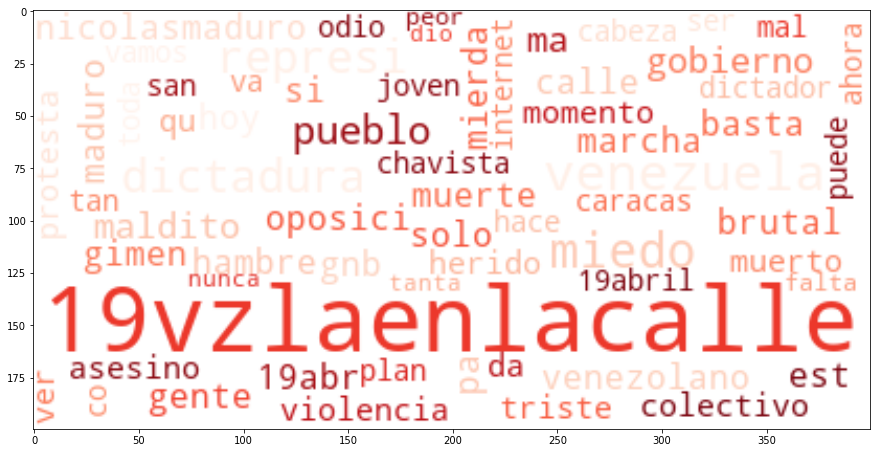

In [72]:
wc_mediumsent = make_wordcloud(tweets_mediumsent_list)
plt.figure(figsize=(15,10))
plt.imshow(wc_lowsent, interpolation='bilinear')

In [75]:
# Remove hastag from lists 
hashtag = '19vzlaenlacalle'
tweets_lowsent_nohashtag = [word for word in tweets_lowsent_list if word not in hashtag]
tweets_highsent_nohashtag = [word for word in tweets_highsent_list if word not in hashtag]
tweets_mediumsent_nohashtag = [word for word in tweets_mediumsent_list if word not in hashtag]

## Wordclouds without hashtag

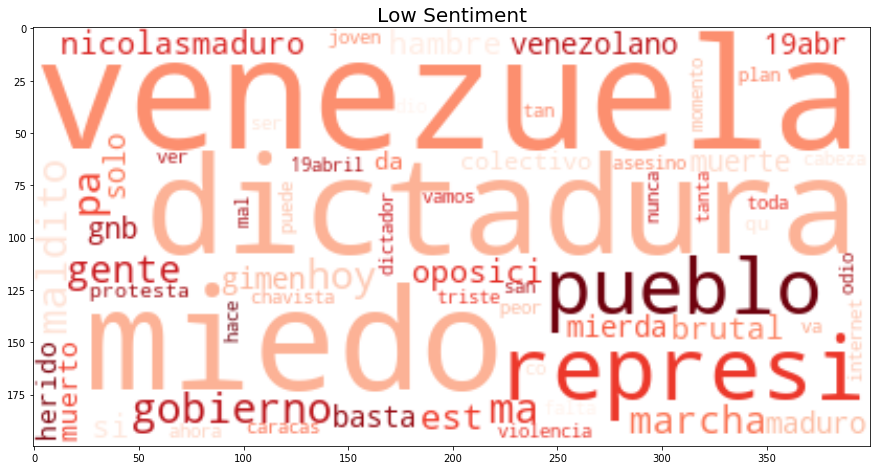

In [87]:
# Wordcloud low sentiment, no hashtag
wc_lowsent_nh = make_wordcloud(tweets_lowsent_nohashtag)
plt.figure(figsize=(15,10))
plt.title('Low Sentiment', fontsize=20)
plt.imshow(wc_lowsent_nh, interpolation='bilinear')

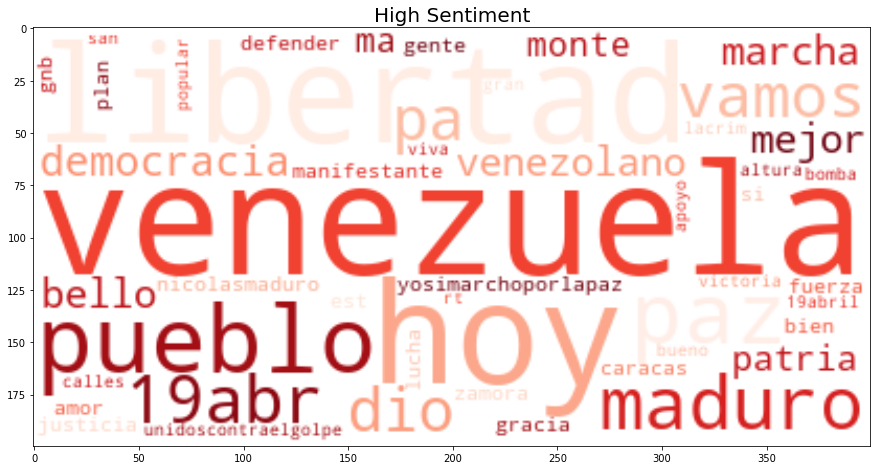

In [88]:
# Wordcloud low sentiment, no hashtag
wc_highsent_nh = make_wordcloud(tweets_highsent_nohashtag)
plt.figure(figsize=(15,10))
plt.title('High Sentiment', fontsize=20)
plt.imshow(wc_highsent_nh, interpolation='bilinear')

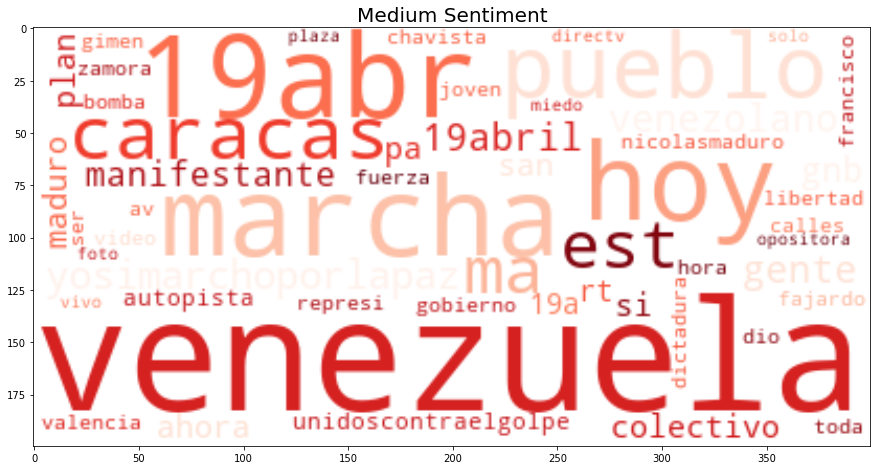

In [89]:
# Wordcloud medium sentiment, no hashtag
wc_mediumsent_nh = make_wordcloud(tweets_mediumsent_nohashtag)
plt.figure(figsize=(15,10))
plt.title('Medium Sentiment', fontsize=20)
plt.imshow(wc_mediumsent_nh, interpolation='bilinear')

## Sentiment and number of retweets

In [91]:
df_es.head()

,Unnamed: 0,username,date,retweets,favorites,text,geo,mentions,hashtags,id,permalink,retweet,clean_text,language,sentiment,text_nopictwit,tokens,nostop,lemmas
0,0,XIOMARAPINAR2,2017-04-21 19:44,0,0,somos el 95 de opositores el cne lo q tiene q...,NaN,NaN,#,8.555678e+17,https://twitter.com/XIOMARAPINAR2/status/85556...,Somos el 95% de OPOSITORES el CNE lo q tiene q...,Somos el 95 de OPOSITORES el CNE lo q tiene q...,es,0.860895,somos el 95 de opositores el cne lo q tiene q...,"[somos, el, 95, de, opositores, el, cne, lo, q...","[95, opositores, cne, q, q, redactar, credenci...","[95, opositores, cne, q, q, redactar, credenci..."
1,1,desdevargas,2017-04-21 17:37,1,1,19vzlaenlacalle y en los puntos rojos de var...,NaN,@CuatroFDigital @,#,8.555359e+17,https://twitter.com/desdevargas/status/8555359...,# 19VzlaEnLaCalle y en los puntos rojos de Var...,y en los puntos rojos de Vargas en defensa de...,es,0.609140,19vzlaenlacalle y en los puntos rojos de var...,"[19vzlaenlacalle, y, en, los, puntos, rojos, d...","[19vzlaenlacalle, puntos, rojos, vargas, defen...","[19vzlaenlacalle, puntos, rojos, vargas, defen..."
2,2,incesamazonas,2017-04-21 16:38,0,0,retweeted antv venezuela ( 19vzlaenlacalle e...,NaN,@ANTV_VENEZUELA,# #,8.555210e+17,https://twitter.com/incesamazonas/status/85552...,# 19VzlaEnLaCalle El # 19Abr el Pueblo con pa...,El el Pueblo con paz toma Caracas y,es,0.860037,retweeted antv venezuela ( 19vzlaenlacalle e...,"[retweeted, antv, venezuela, 19vzlaenlacalle, ...","[retweeted, antv, venezuela, 19vzlaenlacalle, ...","[retweeted, antv, venezuela, 19vzlaenlacalle, ..."
3,3,incesamazonas,2017-04-21 16:28,0,0,retweeted elias jaua ( at jauamiranda) 19vz...,NaN,@,#,8.555187e+17,https://twitter.com/incesamazonas/status/85551...,# 19vzlaenlacalle logró el triunfo de la Inde...,logró el triunfo de la Independencia y La Pa...,es,1.000000,retweeted elias jaua ( at jauamiranda) 19vz...,"[retweeted, elias, jaua, at, jauamiranda, 19vz...","[retweeted, elias, jaua, at, jauamiranda, 19vz...","[retweeted, elia, jaua, at, jauamiranda, 19vzl..."
4,4,FreeCubaVzla,2017-04-21 14:13,0,0,retweeted mando militar ( at mandomilitar) ...,NaN,@,#,8.554845e+17,https://twitter.com/FreeCubaVzla/status/855484...,# 19vzlaenlacalle Momento cuando las personas...,Momento cuando las personas son obligadas a ...,es,0.366838,retweeted mando militar ( at mandomilitar) ...,"[retweeted, mando, militar, at, mandomilitar, ...","[retweeted, mando, militar, at, mandomilitar, ...","[retweeted, mando, militar, at, mandomilitar, ..."


## Relation between sentiment and number of retweets?

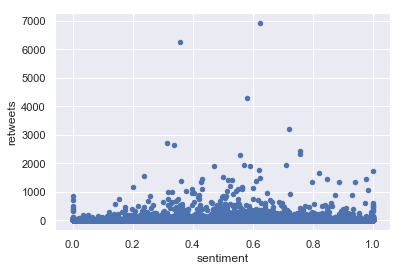

In [191]:
df_es.plot(kind='scatter', x='sentiment', y='retweets')

In [97]:
correlation = df_es['sentiment'].corr(df_es['retweets'])   # Pearson correlation
print(correlation)

0.018629527322001287


## Sentiment and retweets over time

In [102]:
df_es['date'] = pd.to_datetime(df_es['date'], errors='coerce')

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [ ]:
df_es = df_es.set_index(pd.DatetimeIndex(df_es['date']))

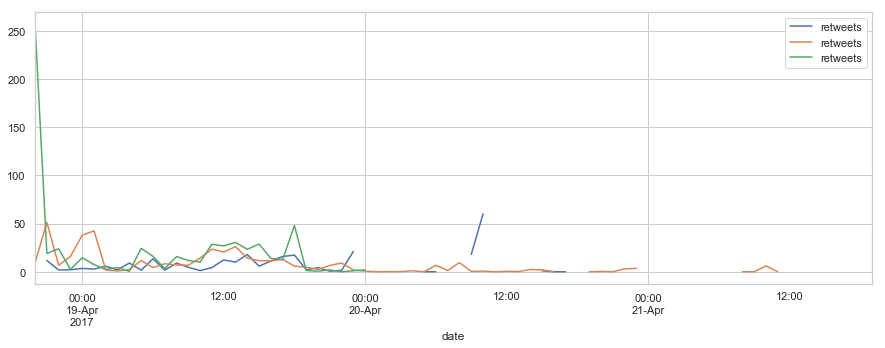

In [239]:
#df_lowsent = df_es[df_es['sentiment']<.20]
#df_lowsent = df_lowsent.set_index(pd.DatetimeIndex(df_lowsent['date']))
#df_lowsent = df_lowsent.resample('H').mean()
#df_lowsent.plot( y=['sentiment'], figsize=(10,5))

#df_highsent = df_es[df_es['sentiment']>.80]
#df_highsent = df_highsent.set_index(pd.DatetimeIndex(df_highsent['date']))
#df_highsent = df_highsent.resample('H').mean()
#df_highsent.plot( y=['sentiment'], figsize=(10,5))

#df_mediumsent = df_es[(df_es['sentiment']>.40) & (df_es['sentiment']<.60)]
#df_mediumsent = df_mediumsent.set_index(pd.DatetimeIndex(df_mediumsent['date']))
#df_mediumsent = df_mediumsent.resample('H').mean()

ax = df_lowsent.plot(y=['retweets'], figsize=(15,5))   # blue
df_mediumsent.plot(ax=ax, y=['retweets'])   # orange
df_highsent.plot(ax=ax, y=['retweets'])   # green 

## Low sentiment vectors

In [157]:
tweets_lowsent_doc = df_lowsent['lemmas'].tolist()

In [158]:
# Continuous Bag of Words (CBOW) model (predict word from context)
model1 = Word2Vec(tweets_lowsent_doc, size=100, window=5, min_count=3, workers=4)

In [159]:
# Train model
model1.train(tweets_lowsent_doc, total_examples=len(tweets_lowsent_doc), epochs=10)

(122548, 207400)

In [160]:
len(tweets_lowsent_doc)

1880

In [161]:
# Save model
#model1.save("low_sentiment.model")

In [162]:
# Get vectors
lowsent_vectors = model1.wv

In [200]:
# Fit a 2D PCA model to the vectors
X_1 = model1[model1.wv.vocab]
pca_1 = PCA(n_components=2)
result1 = pca_1.fit_transform(X_1)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1212


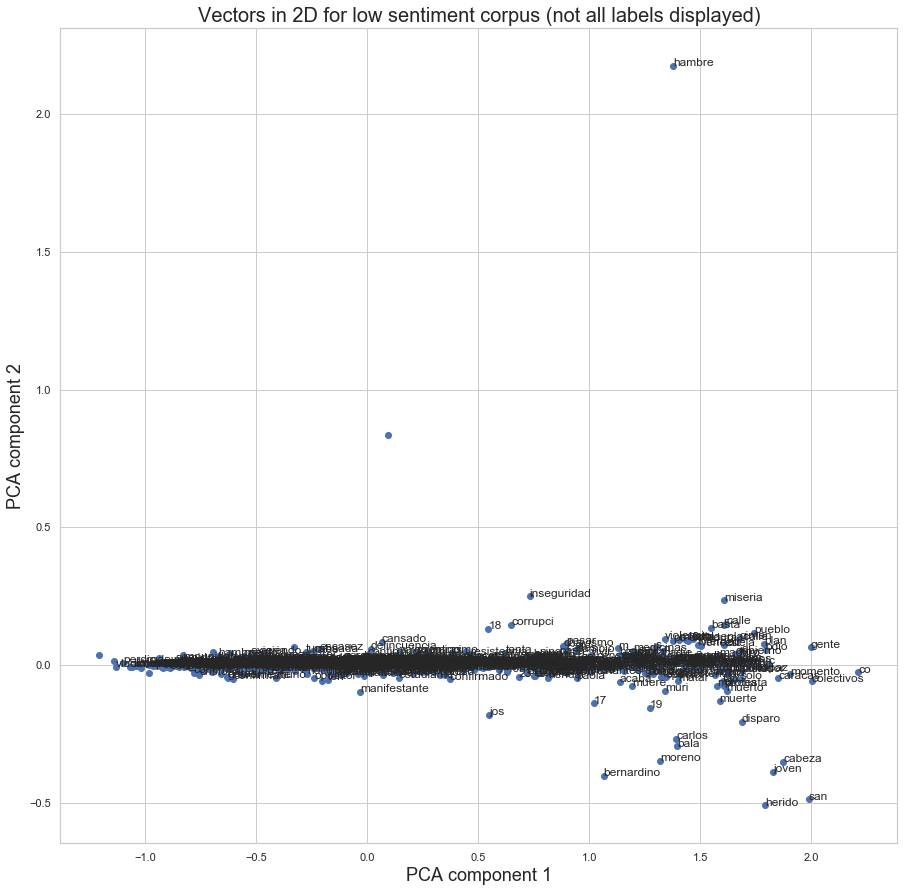

In [201]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result1[:, 0], result1[:, 1])
words = list(model1.wv.vocab)
print(len(words))
words_part = words[0:1000]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result1[i, 0], result1[i, 1]))
plt.title('Vectors in 2D for low sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()


## High sentiment vectors

In [166]:
tweets_highsent_doc = df_highsent['lemmas'].tolist()

# Continuous Bag of Words (CBOW) model (predict word from context)
model2 = Word2Vec(tweets_highsent_doc, size=100, window=5, min_count=3, workers=4)

# Train model
model2.train(tweets_highsent_doc, total_examples=len(tweets_highsent_doc), epochs=10)

# Save model
#model2.save("high_sentiment.model")

# Get vectors
highsent_vectors = model2.wv

In [179]:
# Fit a 2D PCA model to the vectors
X_2 = model2[model2.wv.vocab]
pca_2 = PCA(n_components=2)
result2 = pca_2.fit_transform(X_2)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


1099


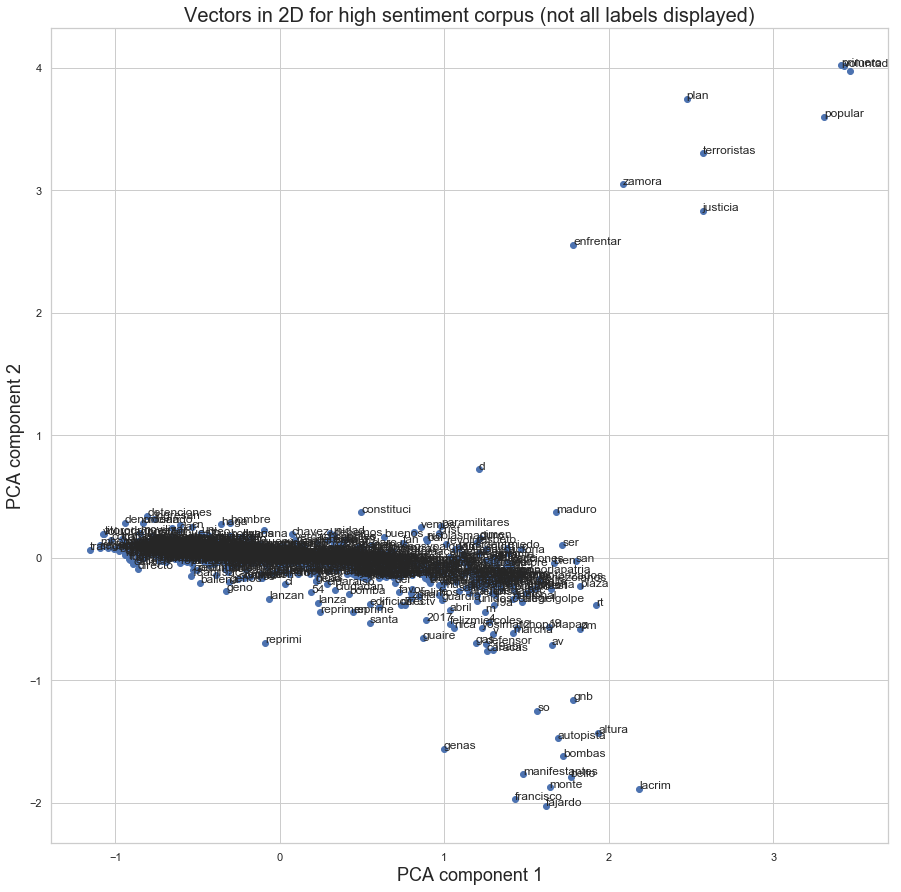

In [198]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result2[:, 0], result2[:, 1])
words = list(model2.wv.vocab)
print(len(words))
words_part = words[0:1000]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result2[i, 0], result2[i, 1]))
plt.title('Vectors in 2D for high sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()

## Medium sentiment vectors

In [171]:
tweets_mediumsent_doc = df_mediumsent['lemmas'].tolist()

# Continuous Bag of Words (CBOW) model (predict word from context)
model3 = Word2Vec(tweets_mediumsent_doc, size=100, window=5, min_count=3, workers=4)

# Train model
model3.train(tweets_mediumsent_doc, total_examples=len(tweets_mediumsent_doc), epochs=10)

# Save model
#model3.save("medium_sentiment.model")

# Get vectors
mediumsent_vectors = model3.wv

In [173]:
# Fit a 2D PCA model to the vectors
X_3 = model3[model3.wv.vocab]
pca_3 = PCA(n_components=2)
result3 = pca_3.fit_transform(X_3)

/anaconda3/envs/hackathon/lib/python3.6/site-packages/ipykernel_launcher.py:2: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


3175


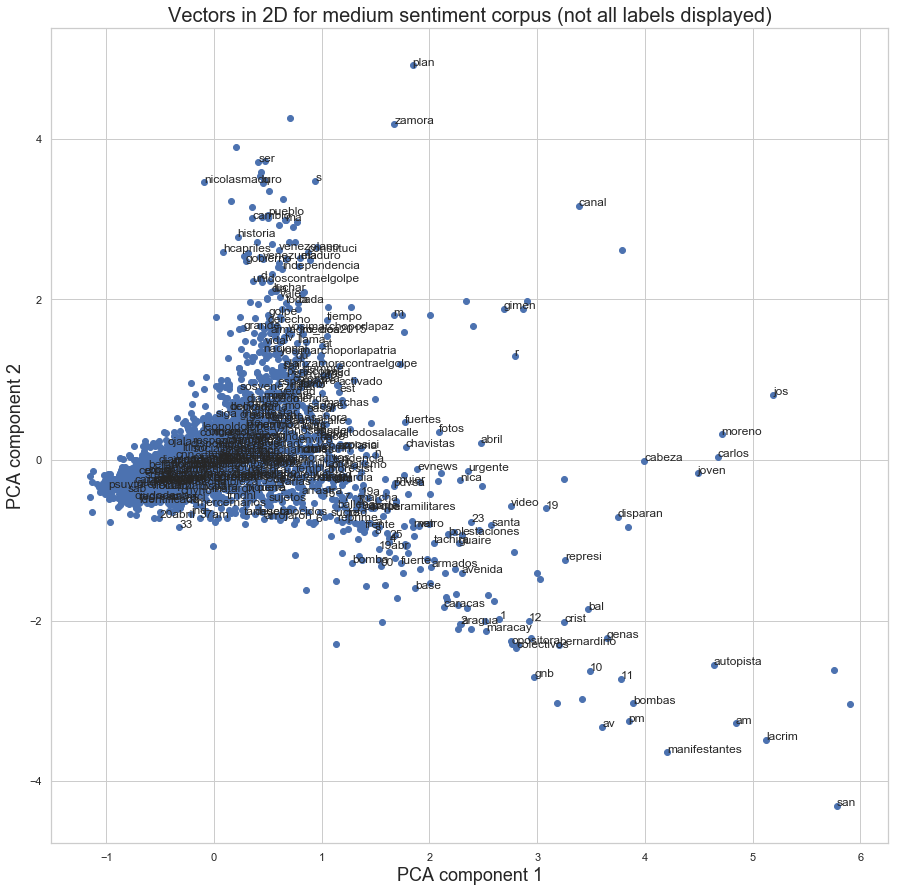

In [202]:
# Create a scatter plot of the projection
plt.figure(figsize=(15,15))
plt.scatter(result3[:, 0], result3[:, 1])
words = list(model3.wv.vocab)
print(len(words))
words_part = words[0:300]
for i, word in enumerate(words_part):
    plt.annotate(word, xy=(result3[i, 0], result3[i, 1]))
plt.title('Vectors in 2D for medium sentiment corpus (not all labels displayed)', fontsize=20)
plt.xlabel('PCA component 1', fontsize=18)
plt.ylabel('PCA component 2', fontsize=18)
plt.show()

## Compare models

In [184]:
# Words most similar to 'fear' in low sentiment corpus
w1 = "miedo"   # fear
model1.wv.most_similar(positive=w1)

[('gente', 0.9994407296180725),
 ('pueblo', 0.9994176626205444),
 ('falta', 0.9994010925292969),
 ('salir', 0.9993812441825867),
 ('calles', 0.9993554353713989),
 ('venezuela', 0.9992777109146118),
 ('da', 0.9992725849151611),
 ('q', 0.9992492198944092),
 ('hoy', 0.9992393255233765),
 ('19vzlaenlacalle', 0.9992068409919739)]

In [186]:
# Words most similar to 'fear' in high sentiment corpus
model2.wv.most_similar(positive=w1)

[('ser', 0.9994771480560303),
 ('bien', 0.9986717700958252),
 ('recuperar', 0.9985935688018799),
 ('merecemos', 0.9985777735710144),
 ('exige', 0.9982781410217285),
 ('vida', 0.9981569051742554),
 ('respeto', 0.9979019165039062),
 ('dictadura', 0.9978753924369812),
 ('buena', 0.9977855682373047),
 ('siempre', 0.9977173805236816)]

In [188]:
# Words most similar to 'fear' in medium sentiment corpus
model3.wv.most_similar(positive=w1)

[('libertad', 0.9558271169662476),
 ('exigir', 0.9553444385528564),
 ('peleando', 0.9480494856834412),
 ('sali', 0.9433436989784241),
 ('dictadura', 0.9359396696090698),
 ('exigiendo', 0.9334856867790222),
 ('protestar', 0.9323877096176147),
 ('democracia', 0.9288467168807983),
 ('calle', 0.9281280040740967),
 ('queremos', 0.923920750617981)]